<h3><center>Bayesian Networks with Pomegranate</center></h3>

Author: Jacob Schreiber <br>
Modified & Presented by : ACI TA Team

Bayesian networks are a powerful inference tool, in which a set of variables are represented as nodes, and the lack of an edge represents a conditional independence statement between the two variables, and an edge represents a dependence between the two variables. One of the powerful components of a Bayesian network is the ability to infer the values of certain variables, given observed values for another set of variables. These are referred to as the 'hidden' and 'observed' variables respectively, and need not be set at the time the network is created. The same network can have a different set of variables be hidden or observed between two data points. The more values which are observed, the closer the inferred values will be to the truth.

While Bayesian networks can have extremely complex emission probabilities, usually Gaussian or conditional Gaussian distributions, pomegranate currently supports only discrete Bayesian networks. Bayesian networks are explicitly turned into Factor Graphs when inference is done, wherein the Bayesian network is turned into a bipartite graph with all variables having marginal nodes on one side, and joint tables on the other.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy

from pomegranate import *

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate

Thu Feb 27 2020 

numpy 1.16.5
scipy 1.2.2
pomegranate 0.10.0

compiler   : GCC 7.4.0
system     : Linux
release    : 5.3.0-40-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 1
interpreter: 64bit


### The Monty Hall Gameshow

The Monty Hall problem arose from the gameshow <i>Let's Make a Deal</i>, where a guest had to choose which one of three doors had a prize behind it. The twist was that after the guest chose, the host, originally Monty Hall, would then open one of the doors the guest did not pick and ask if the guest wanted to switch which door they had picked. Initial inspection may lead you to believe that if there are only two doors left, there is a 50-50 chance of you picking the right one, and so there is no advantage one way or the other. However, it has been proven both through simulations and analytically that there is in fact a 66% chance of getting the prize if the guest switches their door, regardless of the door they initially went with.

We can reproduce this result using Bayesian networks with three nodes, one for the guest, one for the prize, and one for the door Monty chooses to open. The door the guest initially chooses and the door the prize is behind are completely random processes across the three doors, but the door which Monty opens is dependent on both the door the guest chooses (it cannot be the door the guest chooses), and the door the prize is behind (it cannot be the door with the prize behind it).

To create the Bayesian network in pomegranate, we first create the distributions which live in each node in the graph. For a discrete (aka categorical) bayesian network we use DiscreteDistribution objects for the root nodes and ConditionalProbabilityTable objects for the inner and leaf nodes. The columns in a ConditionalProbabilityTable correspond to the order in which the parents (the second argument) are specified, and the last column is the value the ConditionalProbabilityTable itself takes. In the case below, the first column corresponds to the value 'guest' takes, then the value 'prize' takes, and then the value that 'monty' takes. 'B', 'C', 'A' refers then to the probability that Monty reveals door 'A' given that the guest has chosen door 'B' and that the prize is actually behind door 'C', or P(Monty='A'|Guest='B', Prize='C').

In [2]:
# The guests initial door selection is completely random
guest = DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})

# The door the prize is behind is also completely random
prize = DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})

    # Monty is dependent on both the guest and the prize. 
monty = ConditionalProbabilityTable(
        [[ 'A', 'A', 'A', 0.0 ],
         [ 'A', 'A', 'B', 0.5 ],
         [ 'A', 'A', 'C', 0.5 ],
         [ 'A', 'B', 'A', 0.0 ],
         [ 'A', 'B', 'B', 0.0 ],
         [ 'A', 'B', 'C', 1.0 ],
         [ 'A', 'C', 'A', 0.0 ],
         [ 'A', 'C', 'B', 1.0 ],
         [ 'A', 'C', 'C', 0.0 ],
         [ 'B', 'A', 'A', 0.0 ],
         [ 'B', 'A', 'B', 0.0 ],
         [ 'B', 'A', 'C', 1.0 ],
         [ 'B', 'B', 'A', 0.5 ],
         [ 'B', 'B', 'B', 0.0 ],
         [ 'B', 'B', 'C', 0.5 ],
         [ 'B', 'C', 'A', 1.0 ],
         [ 'B', 'C', 'B', 0.0 ],
         [ 'B', 'C', 'C', 0.0 ],
         [ 'C', 'A', 'A', 0.0 ],
         [ 'C', 'A', 'B', 1.0 ],
         [ 'C', 'A', 'C', 0.0 ],
         [ 'C', 'B', 'A', 1.0 ],
         [ 'C', 'B', 'B', 0.0 ],
         [ 'C', 'B', 'C', 0.0 ],
         [ 'C', 'C', 'A', 0.5 ],
         [ 'C', 'C', 'B', 0.5 ],
         [ 'C', 'C', 'C', 0.0 ]], [guest, prize])  

Next, we pass these distributions into state objects along with the name for the node.

In [3]:
# State objects hold both the distribution, and a high level name.
s1 = State(guest, name="guest")
s2 = State(prize, name="prize")
s3 = State(monty, name="monty")

Then we add the states to the network, exactly like we did when making a HMM. In the future, all matrices of data should have their columns organized in the same order that the states are added to the network. The way the states are added to the network makes no difference to it, and so you should add the states according to how the columns are organized in your data.

In [4]:
# Create the Bayesian network object with a useful name
model = BayesianNetwork("Monty Hall Problem")

# Add the three states to the network 
model.add_states(s1, s2, s3)

Then we need to add edges to the model. The edges represent which states are parents of which other states. This is currently a bit redundant with passing in the distribution objects that are parents for each ConditionalProbabilityTable. For now edges are added from parent -> child by calling `model.add_edge(parent, child)`.

In [5]:
# Add edges which represent conditional dependencies, where the second node is 
# conditionally dependent on the first node (Monty is dependent on both guest and prize)
model.add_edge(s1, s3)
model.add_edge(s2, s3)

Lastly, the model must be baked to finalize the internals. Since Bayesian networks use factor graphs for inference, an explicit factor graph is produced from the Bayesian network during the bake step.

In [6]:
model.bake()

#### Predicting Probabilities

We can calculate probabilities of a sample under the Bayesian network in the same way that we can calculate probabilities under other models. In this case, let's calculate the probability that you initially said door A, that Monty then opened door B, but that the actual car was behind door C.

In [7]:
model.probability(['A', 'B', 'C'])

0.11111111111111109

That seems in line with what we know, that there is a 1/9th probability of that happening. 

Next, let's look at an impossible situation. What is the probability of initially saying door A, that Monty opened door B, and that the car was actually behind door B.

In [8]:
model.probability(['A', 'B', 'B'])

0.0

The reason that situation is impossible is because Monty can't open a door that has the car behind it.

#### Performing Inference

Perhaps the most powerful aspect of Bayesian networks is their ability to perform inference. Given any set of observed variables, including no observations, Bayesian networks can make predictions for all other variables. Obviously, the more variables that are observed, the more accurate the predictions will get of the remaining variables. 

pomegranate uses the loopy belief propagation algorithm to do inference. This is an approximate algorithm which can yield exact results in tree-like graphs, and in most other cases still yields good results. Inference on a Bayesian network consists of taking in observations for a subset of the variables and using that to infer the values that the other variables take. The most variables which are observed, the closer the inferred values will be to truth. One of the powers of Bayesian networks is that the set of observed and 'hidden' (or unobserved) variables does not need to be specified beforehand, and can change from sample to sample.

We can run inference using the `predict_proba` method and passing in a dictionary of values, where the key is the name of the state and the value is the observed value for that state. If we don't supply any values, we get the marginal of the graph, which is just the frequency of each value for each variable over an infinite number of randomly drawn samples from the graph.

Lets see what happens when we look at the marginal of the Monty hall network.

In [9]:
model.predict_proba({})

array([{
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.3333333333333333,
            "C" :0.3333333333333333,
            "B" :0.3333333333333333
        }
    ],
    "name" :"DiscreteDistribution"
},
       {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.3333333333333333,
            "C" :0.3333333333333333,
            "B" :0.3333333333333333
        }
    ],
    "name" :"DiscreteDistribution"
},
       {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.3333333333333333,
            "C" :0.3333333333333333,
            "B" :0.3333333333333333
        }
    ],
    "name" :"DiscreteDistribution"
}], dtype=object)

We are returned three `DiscreteDistribution` objects, each representing the marginal distribution for each variable, in the same order they were put into the model. In this case, they represent the guest, prize, and monty variables respectively. We see that everything is equally likely.

We can also pass in an array where `None` (or `np.nan`) correspond to the unobserved values.

In [10]:
model.predict_proba([None, None, None])

array([{
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.3333333333333333,
            "C" :0.3333333333333333,
            "B" :0.3333333333333333
        }
    ],
    "name" :"DiscreteDistribution"
},
       {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.3333333333333333,
            "C" :0.3333333333333333,
            "B" :0.3333333333333333
        }
    ],
    "name" :"DiscreteDistribution"
},
       {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.3333333333333333,
            "C" :0.3333333333333333,
            "B" :0.3333333333333333
        }
    ],
    "name" :"DiscreteDistribution"
}], dtype=object)

All of the variables that were observed will be the observed value, and all of the variables that were unobserved will be a `DiscreteDistribution` object. This means that `parameters[0]` will return the underlying dictionary used by the distribution.

Now lets do something different, and say that the guest has chosen door 'A'. We do this by passing a dictionary to `predict_proba` with key pairs consisting of the name of the state (in the state object), and the value which that variable has taken, or by passing in a list where the first index is our observation.

In [11]:
model.predict_proba(['A', None, None])

array(['A',
       {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.3333333333333333,
            "C" :0.3333333333333333,
            "B" :0.3333333333333333
        }
    ],
    "name" :"DiscreteDistribution"
},
       {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.0,
            "C" :0.49999999999999983,
            "B" :0.49999999999999983
        }
    ],
    "name" :"DiscreteDistribution"
}], dtype=object)

We can see that now Monty will not open door 'A', because the guest has chosen it. At the same time, the distribution over the prize has not changed, it is still equally likely that the prize is behind each door.

Now, lets say that Monty opens door 'C' and see what happens. Here we use a dictionary rather than a list simply to show how one can use both input forms depending on what is more convenient.

In [12]:
model.predict_proba({'guest': 'A', 'monty': 'C'})

array(['A',
       {
    "frozen" :false,
    "dtype" :"str",
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.3333333333333334,
            "C" :0.0,
            "B" :0.6666666666666664
        }
    ],
    "name" :"DiscreteDistribution"
},
       'C'], dtype=object)

Suddenly, we see that the distribution over prizes has changed. It is now twice as likely that the car is behind the door labeled 'B'. This demonstrates that when on the game show, it is always better to change your initial guess after being shown an open door. Now you could go and win tons of cars, except that the game show got cancelled :( 

## The API

### Initialization

While the methods are similar across all models in pomegranate, Bayesian networks are more closely related to hidden Markov models than the other models. This makes sense, because both of them rely on graphical structures.

The first way to initialize Bayesian networks is to pass in one distribution and state at a time, and then pass in edges. This is similar to hidden Markov models.

In [13]:
d1 = DiscreteDistribution({True: 0.2, False: 0.8})
d2 = DiscreteDistribution({True: 0.6, False: 0.4})
d3 = ConditionalProbabilityTable(
        [[True,  True,  True,  0.2],
         [True,  True,  False, 0.8],
         [True,  False, True,  0.3],
         [True,  False, False, 0.7],
         [False, True,  True,  0.9],
         [False, True,  False, 0.1],
         [False, False, True,  0.4],
         [False, False, False, 0.6]], [d1, d2])

s1 = State(d1, name="s1")
s2 = State(d2, name="s2")
s3 = State(d3, name="s3")

model = BayesianNetwork()
model.add_states(s1, s2, s3)
model.add_edge(s1, s3)
model.add_edge(s2, s3)
model.bake()

The other way is to use the `from_samples` method if given a data set.

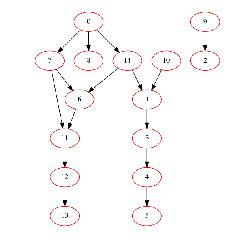

In [14]:
numpy.random.seed(111)

X = numpy.random.randint(2, size=(15, 15))
X[:,5] = X[:,4] = X[:,3]
X[:,11] = X[:,12] = X[:,13]

model = BayesianNetwork.from_samples(X)
model.plot()

The structure learning algorithms are covered more in depth in the accompanying notebook.

We can look at the structure of the network by using the `structure` attribute. Each tuple is a node, and the integers in the tuple correspond to the parents of the node.

In [15]:
model.structure

((),
 (10, 14),
 (9,),
 (1,),
 (3,),
 (4,),
 (7, 14),
 (0,),
 (0,),
 (),
 (),
 (6, 7),
 (11,),
 (12,),
 (0,))

### Prediction

The prediction method is similar to the other models. Inference is done using loopy belief propogation, which is an approximate version of the forward-backward algorithm that can be significantly faster while still precise. 

In [16]:
model.predict([[False, False, False, False, None, None, False, None, False, None, True, None, None, True, False]])

[array([False, False, False, False, 0, 0, False, 1, False, 0, True, 1, 1,
        True, False], dtype=object)]

The predict method will simply return the argmax of all the distributions after running the `predict_proba` method. 

In [17]:
model.predict_proba([[False, False, False, False, None, None, False, None, False, None, 
                      True, None, None, True, False]])

[array([False, False, False, False,
        {
     "frozen" :false,
     "dtype" :"numpy.int64",
     "class" :"Distribution",
     "parameters" :[
         {
             "1" :0.0,
             "0" :1.0
         }
     ],
     "name" :"DiscreteDistribution"
 },
        {
     "frozen" :false,
     "dtype" :"numpy.int64",
     "class" :"Distribution",
     "parameters" :[
         {
             "1" :0.0,
             "0" :1.0
         }
     ],
     "name" :"DiscreteDistribution"
 },
        False,
        {
     "frozen" :false,
     "dtype" :"numpy.int64",
     "class" :"Distribution",
     "parameters" :[
         {
             "1" :0.5555555555555556,
             "0" :0.44444444444444453
         }
     ],
     "name" :"DiscreteDistribution"
 },
        False,
        {
     "frozen" :false,
     "dtype" :"numpy.int64",
     "class" :"Distribution",
     "parameters" :[
         {
             "1" :0.0,
             "0" :1.0
         }
     ],
     "name" :"DiscreteDistribution"